In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

import src.artifice_utils
import src.experiment_utils
import src.uniform_writes
import src.utils

## Data and Directory Setup

In [3]:
in_data_path = os.path.abspath("disk-change-data")
if not os.path.exists(in_data_path):
    !./src/download-data.sh

processed_data_path = os.path.join(in_data_path, "processed-data")
if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

results_path = "results"
if not os.path.exists(results_path):
    os.makedirs(results_path)

figs_path = "figs"
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.7M  100 16.7M    0     0  3146k      0  0:00:05  0:00:05 --:--:-- 3446k
Archive:  disk-change-data.zip
   creating: disk-change-data/
  inflating: disk-change-data/06-16.csv  
  inflating: disk-change-data/04-12.csv  
  inflating: disk-change-data/06-17.csv  
  inflating: disk-change-data/06-01.csv  
  inflating: disk-change-data/06-15.csv  
  inflating: disk-change-data/06-14.csv  
  inflating: disk-change-data/06-04.csv  
  inflating: disk-change-data/06-10.csv  
  inflating: disk-change-data/04-29.csv  
  inflating: disk-change-data/03-08.csv  
  inflating: disk-change-data/04-15.csv  
  inflating: disk-change-data/04-14.csv  
  inflating: disk-change-data/03-09.csv  
  inflating: disk-change-data/06-11.csv  
  inflating: disk-change-data/06-07.csv  
  inflating: disk-change-data/04-16.csv  
  inflating: disk-change-data

# Data Processing

This determines which change records found in `in_data_path` need to be processed.
Processing a file consists of counting chains of length $n$ in individual change records and calculating the probability of that chain.
It then loads the processed files for further analysis.

The `download-data.sh` script downloads the processed data as well as the raw data. Delete the `processed-data` directory if you would like to run the processing yourself, but this process takes about an hour.

In [10]:
raw_basenames = src.utils.get_csv_files(in_data_path)
processed_basenames = src.utils.get_csv_files(processed_data_path)

files_to_process = set(raw_basenames) - set(processed_basenames)
for filename in tqdm(files_to_process):
    abs_filename = os.path.abspath(os.path.join(in_data_path, filename))
    raw_data = np.fromfile(abs_filename, sep="\n", dtype=int)

    data_dict = src.uniform_writes.construct_consecutive_changes_dict(raw_data)
    data = src.uniform_writes.consecutive_change_dict_to_matrix(data_dict)

    processed_file = os.path.abspath(os.path.join(processed_data_path, os.path.basename(filename)))
    data = pd.DataFrame(data, columns=['length', "# occurences", "probability"])
    data.to_csv(processed_file, index=False)

processed_filenames = [os.path.abspath(os.path.join(processed_data_path, processed_basenames)) for processed_basenames in src.utils.get_csv_files(processed_data_path)]
disk_set = [pd.read_csv(filename).to_numpy() for filename in processed_filenames]

0it [00:00, ?it/s]


# Experiment Setup

## Disk Parameters

We assume a 1tb disk with 100gb of freespace. We assume that 25gb of public changes are made to cover the Artifice changes.

In [11]:
blocks_per_gb = 250000 # 4kb blocks
disk_blocks = 1000 * blocks_per_gb # 1tb
freespace_blocks = 100 * blocks_per_gb # 100gb

public_block_changes = 25 * blocks_per_gb # 25gb worth of block changes

## Artifice Setup
We construct Artifice instances of size 250mb, 500mb, 750mb, 1gb, and 1.25gb.
With our `artifice_shares` and `artifice_threshold` parameters we are essentially copying each Artifice block 6 times to prevent the public changes from overwriting Artifice data, since the public filesystem is oblivious to the Artifice data.

Artifice survivability is a function of the number of public writes, but not all public writes will be to freespace.
We assume that public changes will occur uniformly between used and freespace, thus the number of writes to freespace is 100gb/1000gb.
While not a good assumption,
it is natural and gives Artifice the best chance of surviving while keeping Artifice changes to a minimum.

In [12]:
artifice_sizes = [.25, .5, .75, 1.0, 1.25] # Artifice data capacity in gb.
artifice_data_capacity = np.array([int(size * blocks_per_gb) for size in artifice_sizes])
artifice_shares = 6
artifice_threshold = 1
parity = artifice_shares - artifice_threshold
public_changes_to_freespace = public_block_changes * freespace_blocks / disk_blocks # The number of public changes that overwrite freespace blocks.

artifice_block_changes = np.array([src.artifice_utils.calc_total_size_aont(data_size, parity, artifice_threshold) for data_size in artifice_data_capacity])
artifice_survival_probs = [src.artifice_utils.prob_artifice_alive_aont(artifice_threshold, parity, data_size, public_changes_to_freespace, freespace_blocks) for data_size in artifice_data_capacity]

# This is the probability a write will be a part of a singleton chain.
artifice_singletons_per_write = np.zeros(artifice_block_changes.shape)
#for i in range(artifice_block_changes.shape[0]): # This takes a few minutes. Leave commented unless you'd like to recompute it. There will be slight variations in recomputed values.
#    artifice_singletons_per_write[i] = uniform_writes.experimental_proportion_of_singletons_per_write(disk_blocks, artifice_block_changes[i])
artifice_singletons_per_write = [0.99692205, 0.99392518, 0.99095493, 0.98795007, 0.9851055]

## Artifice Figs

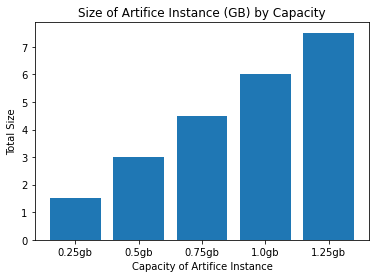

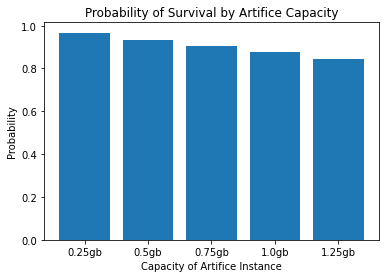

In [13]:
index = np.arange(len(artifice_sizes))
x_axis_labels = [str(x) + "gb" for x in artifice_sizes]

plt.bar(index, artifice_block_changes / blocks_per_gb)

plt.xticks(index, x_axis_labels)
plt.xlabel("Capacity of Artifice Instance")
plt.ylabel("Total Size")
plt.title("Size of Artifice Instance (GB) by Capacity")
plt.show()

plt.bar(index, artifice_survival_probs)

plt.xticks(index, x_axis_labels)
plt.xlabel("Capacity of Artifice Instance")
plt.ylabel("Probability")
plt.title("Probability of Survival by Artifice Capacity")
plt.show()

# Experiment

This experiment aims to distinguish change records with changes due to a public filesystem and a hidden volume (Artifice in this case) from those with no hidden volume.
We sample data constructed from the processed data due to the limited availability of change records from a public filesystem and the even more limited availability of change records produced by a public filesystem and a hidden volume.
For efficiency reasons we do not use data equivalent to the size of a real disk.
This approach is akin to sampling from a full list of chains.

In [14]:
num_trials = 000

train_cutoff = int(np.ceil(0.75 * len(disk_set)))
train_disks = disk_set[:train_cutoff]
test_disks = disk_set[train_cutoff:]

train_size = 10000
test_size = train_size // (4 * len(artifice_sizes))
num_artifice_per_test_set = test_size // 20 # We want 5% artifice data in the "real world."

disk_samples = 1000

public_proportion_of_changes = np.array([public_block_changes / (public_block_changes + artifice_block_change) for artifice_block_change in artifice_block_changes])
public_changes_sample = np.round(public_proportion_of_changes * disk_samples)
artifice_changes_sample = np.array([disk_samples] * public_changes_sample.shape[0]) - public_changes_sample

artifice_singletons = np.round([artifice_changes_sample[i] * artifice_singletons_per_write[i] for i in range(artifice_changes_sample.shape[0])]) # Note: our attack uses only the probability of singleton chains. Since the probability of a 2-chain is small we omit them.

results = np.zeros((5,6))
cols = ["idx", "Accuracy", "Precision", "Recall", "FPR", "FNR"]

for j in tqdm(range(num_trials)):
    raw_training_data, training_truth = src.experiment_utils.gen_data(train_disks, train_size // 2, disk_samples, train_size // 2, public_changes_sample, artifice_singletons)
    training_data = src.experiment_utils.construct_features(raw_training_data)
    lr = src.experiment_utils.train_lr(training_data, training_truth)

    test_data = []
    test_truth = []
    for i in range(len(artifice_singletons)):
        data, truth = src.experiment_utils.gen_data(test_disks, test_size - num_artifice_per_test_set, disk_samples, num_artifice_per_test_set, [public_changes_sample[i]], [artifice_singletons[i]])
        test_data += [src.experiment_utils.construct_features(data)]
        test_truth += [truth]

    intermediate_results = []
    for i in range(len(test_data)):
        pred = lr.predict(test_data[i])
        intermediate_results += [src.experiment_utils.metrics(i, pred, test_truth[i])]
    intermediate_results = np.array(intermediate_results)

    results += intermediate_results
    pd.DataFrame(intermediate_results, columns=cols).to_csv(os.path.join(results_path, f"{j}_results.csv"), index=False)

if num_trials != 0:
    results /= num_trials
    pd.DataFrame(results, columns=cols).to_csv(os.path.join(results_path, "final_results.csv"), index=False)

0it [00:00, ?it/s]


## Experimental Results

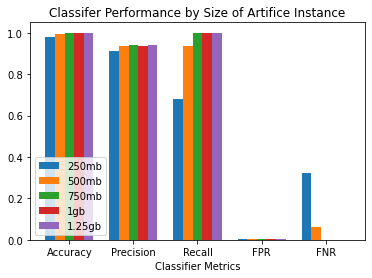

In [16]:
individual_results = [pd.read_csv(os.path.join(results_path, csv), index_col=0).to_numpy() for csv in set(src.utils.get_csv_files(results_path)) - set(["final_results.csv"])]
final_results = pd.read_csv(os.path.join(results_path, "final_results.csv"), index_col=0).to_numpy()
# ci = data_construction.get_ci(individual_results, final_results)

bar_width = 0.15
fig = plt.subplot()
index = np.arange(final_results.shape[0])

label = ["250mb", "500mb", "750mb", "1gb", "1.25gb"]
for i in index:
    plt.bar(index + i * bar_width, final_results[i, :], width=bar_width, label=label[i])

plt.title("Classifer Performance by Size of Artifice Instance")
plt.xlabel("Classifier Metrics")
plt.xticks(index + 2 * bar_width, cols[1:])
plt.legend(loc="lower left")
plt.savefig(os.path.join(figs_path, "perf.png")) 

## Experimental Probability of Chains

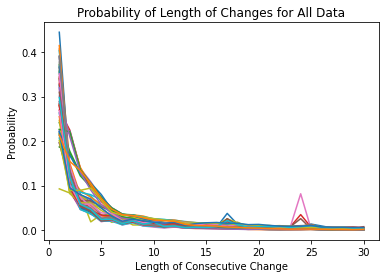

In [17]:
data = []
for disk in disk_set:
    data += [disk[:, 2]]

x_max = 30
x = np.arange(1, x_max + 1)

for d in data:
    plt.plot(x, d[:x_max])

plt.title("Probability of Length of Changes for All Data")
plt.xlabel("Length of Consecutive Change")
plt.ylabel("Probability")
plt.savefig(os.path.join(figs_path, "experimental-chain-probabilities.jpg"))

## Theoretical Probability of Chains 
This figure shows how the probabilities of chains of length $n$ vary when the number of uniform writes is constant and the number of free blocks is variable.
As the number of free blocks increases the probability of chains of length 1 appearing increases.

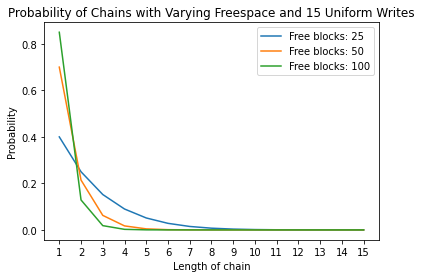

In [18]:
num_free_blocks = [25, 50, 100]
num_uniform_writes = 15

x_axis_labels = [x + 1 for x in range(num_uniform_writes)]

for free_blocks in num_free_blocks:
    (prob_chains, _ , _) = src.uniform_writes.chain_probability(free_blocks, num_uniform_writes)
    plt.plot(prob_chains, label=f"Free blocks: {free_blocks}" )

plt.title(f"Probability of Chains with Varying Freespace and {num_uniform_writes} Uniform Writes")
plt.ylabel("Probability")
plt.xlabel("Length of chain")
plt.xticks(list(range(num_uniform_writes)), x_axis_labels)
plt.legend()
plt.savefig(os.path.join(figs_path, "theoretical-chain-probabilities.jpg"))

## 